In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
"""
0: background,
1: sacrum,
2: right_hip,
3: left_hip,
4: lumbar_vertebra.        
"""        

'\n0: background,\n1: sacrum,\n2: right_hip,\n3: left_hip,\n4: lumbar_vertebra.        \n'

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    Resized,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Activationsd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ScaleIntensityd,
    SaveImaged,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from monai.optimizers import Novograd
from monai.utils import get_torch_version_tuple, set_determinism
from ignite.handlers import EarlyStopping, ModelCheckpoint

print_config()


MONAI version: 0.9.dev2209
Numpy version: 1.21.5
Pytorch version: 1.10.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 9db6e543d6090a3256f20695c1d3224df8cbbc0e
MONAI __file__: C:\Users\Hripsime\anaconda3\envs\abys\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 8.4.0
Tensorboard version: 2.8.0
gdown version: 4.2.1
TorchVision version: 0.11.3
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.1
einops version: 0.4.0
transformers version: 4.16.2
mlflow version: 1.23.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [4]:
root_dir  = '../projects/CTPelvic1K_data/'

data_image = os.path.join(root_dir, 'images')
data_mask = os.path.join(root_dir, 'masks')


## Set dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(data_image, "*data.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_mask, "*mask_4label.nii.gz")))

data_dicts = [ {"image": image_name, "mask": label_name} for image_name, label_name in zip(train_images, train_labels) ]
train_files, val_files = data_dicts[:-10], data_dicts[-10:]

In [6]:
set_determinism(seed=0)

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        #DataStatsd(keys=["image", "label"], prefix='Data', data_type=True, data_shape=True, value_range=True, data_value=False),
        
        RandCropByPosNegLabeld(
            keys=["image", "mask"],
            label_key="mask",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        
        EnsureTyped(keys=["image", "mask"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        EnsureTyped(keys=["image", "mask"]),
    ]
)



In [8]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)


Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.86s/it]


## Create Model, Loss, Optimizer

In [14]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer

VAL_AMP = True #Automatic mixed precision to accelerate training speed and reduce a memory usage
learning_rate = 2e-4

device=torch.device("cuda:0")     
#device=torch.device("cpu")      
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=5,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True) 

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
#optimizer = Novograd(model.parameters(), learning_rate * 10)
dice_metric = DiceMetric(include_background=False, reduction="mean")


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(160, 160, 160),
            sw_batch_size=4,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
    
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True    

## Execute a typical PyTorch training process

In [15]:
max_epochs = 400
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=5)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=5)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["mask"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["mask"].to(device),
                )
                
                val_outputs = inference(val_inputs)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/400
1/31, train_loss: 0.8958
2/31, train_loss: 0.9034
3/31, train_loss: 0.9020
4/31, train_loss: 0.8811
5/31, train_loss: 0.9092
6/31, train_loss: 0.8727
7/31, train_loss: 0.8824
8/31, train_loss: 0.8790
9/31, train_loss: 0.8735
10/31, train_loss: 0.8749
11/31, train_loss: 0.8622
12/31, train_loss: 0.8683
13/31, train_loss: 0.8650
14/31, train_loss: 0.8620
15/31, train_loss: 0.8692
16/31, train_loss: 0.8734
17/31, train_loss: 0.8692
18/31, train_loss: 0.8479
19/31, train_loss: 0.8556
20/31, train_loss: 0.8527
21/31, train_loss: 0.8359
22/31, train_loss: 0.8721
23/31, train_loss: 0.8148
24/31, train_loss: 0.8650
25/31, train_loss: 0.8666
26/31, train_loss: 0.8473
27/31, train_loss: 0.8595
28/31, train_loss: 0.8216
29/31, train_loss: 0.8350
30/31, train_loss: 0.8622
31/31, train_loss: 0.8366
epoch 1 average loss: 0.8650
saved new best metric model
current epoch: 1 current mean dice: 0.1171
best mean dice: 0.1171 at epoch: 1
----------
epoch 2/400
1/31, train_loss: 0.81

22/31, train_loss: 0.5504
23/31, train_loss: 0.5902
24/31, train_loss: 0.5146
25/31, train_loss: 0.5505
26/31, train_loss: 0.6559
27/31, train_loss: 0.4957
28/31, train_loss: 0.5978
29/31, train_loss: 0.5654
30/31, train_loss: 0.4865
31/31, train_loss: 0.5952
epoch 9 average loss: 0.5829
saved new best metric model
current epoch: 9 current mean dice: 0.4927
best mean dice: 0.4927 at epoch: 9
----------
epoch 10/400
1/31, train_loss: 0.5397
2/31, train_loss: 0.6329
3/31, train_loss: 0.6678
4/31, train_loss: 0.5371
5/31, train_loss: 0.5972
6/31, train_loss: 0.5355
7/31, train_loss: 0.5718
8/31, train_loss: 0.5921
9/31, train_loss: 0.6009
10/31, train_loss: 0.6130
11/31, train_loss: 0.4674
12/31, train_loss: 0.6878
13/31, train_loss: 0.4739
14/31, train_loss: 0.5161
15/31, train_loss: 0.5831
16/31, train_loss: 0.5984
17/31, train_loss: 0.5780
18/31, train_loss: 0.4700
19/31, train_loss: 0.5031
20/31, train_loss: 0.6421
21/31, train_loss: 0.5375
22/31, train_loss: 0.4943
23/31, train_loss:

11/31, train_loss: 0.3777
12/31, train_loss: 0.4671
13/31, train_loss: 0.3939
14/31, train_loss: 0.3556
15/31, train_loss: 0.3008
16/31, train_loss: 0.4870
17/31, train_loss: 0.4063
18/31, train_loss: 0.4428
19/31, train_loss: 0.4176
20/31, train_loss: 0.4734
21/31, train_loss: 0.4687
22/31, train_loss: 0.3672
23/31, train_loss: 0.5136
24/31, train_loss: 0.2965
25/31, train_loss: 0.4895
26/31, train_loss: 0.2956
27/31, train_loss: 0.3716
28/31, train_loss: 0.4292
29/31, train_loss: 0.4840
30/31, train_loss: 0.5694
31/31, train_loss: 0.4608
epoch 18 average loss: 0.4428
saved new best metric model
current epoch: 18 current mean dice: 0.7007
best mean dice: 0.7007 at epoch: 18
----------
epoch 19/400
1/31, train_loss: 0.3821
2/31, train_loss: 0.5411
3/31, train_loss: 0.3660
4/31, train_loss: 0.3827
5/31, train_loss: 0.5012
6/31, train_loss: 0.4013
7/31, train_loss: 0.2845
8/31, train_loss: 0.3450
9/31, train_loss: 0.3962
10/31, train_loss: 0.3670
11/31, train_loss: 0.6107
12/31, train_lo

1/31, train_loss: 0.1900
2/31, train_loss: 0.5144
3/31, train_loss: 0.3733
4/31, train_loss: 0.4887
5/31, train_loss: 0.3120
6/31, train_loss: 0.4452
7/31, train_loss: 0.3424
8/31, train_loss: 0.3800
9/31, train_loss: 0.2851
10/31, train_loss: 0.3424
11/31, train_loss: 0.3613
12/31, train_loss: 0.2762
13/31, train_loss: 0.2335
14/31, train_loss: 0.3085
15/31, train_loss: 0.6119
16/31, train_loss: 0.3354
17/31, train_loss: 0.4138
18/31, train_loss: 0.2102
19/31, train_loss: 0.3298
20/31, train_loss: 0.3841
21/31, train_loss: 0.4452
22/31, train_loss: 0.3632
23/31, train_loss: 0.2612
24/31, train_loss: 0.5539
25/31, train_loss: 0.5822
26/31, train_loss: 0.3970
27/31, train_loss: 0.2710
28/31, train_loss: 0.2269
29/31, train_loss: 0.3837
30/31, train_loss: 0.4110
31/31, train_loss: 0.5212
epoch 27 average loss: 0.3727
current epoch: 27 current mean dice: 0.7665
best mean dice: 0.8276 at epoch: 26
----------
epoch 28/400
1/31, train_loss: 0.3399
2/31, train_loss: 0.3417
3/31, train_loss: 0

28/31, train_loss: 0.4622
29/31, train_loss: 0.4351
30/31, train_loss: 0.2457
31/31, train_loss: 0.4422
epoch 35 average loss: 0.3838
saved new best metric model
current epoch: 35 current mean dice: 0.8908
best mean dice: 0.8908 at epoch: 35
----------
epoch 36/400
1/31, train_loss: 0.4599
2/31, train_loss: 0.2476
3/31, train_loss: 0.2025
4/31, train_loss: 0.2537
5/31, train_loss: 0.3601
6/31, train_loss: 0.3055
7/31, train_loss: 0.2204
8/31, train_loss: 0.3496
9/31, train_loss: 0.4832
10/31, train_loss: 0.1932
11/31, train_loss: 0.2636
12/31, train_loss: 0.3109
13/31, train_loss: 0.3264
14/31, train_loss: 0.3349
15/31, train_loss: 0.3884
16/31, train_loss: 0.4039
17/31, train_loss: 0.5044
18/31, train_loss: 0.3317
19/31, train_loss: 0.3414
20/31, train_loss: 0.2134
21/31, train_loss: 0.3281
22/31, train_loss: 0.4999
23/31, train_loss: 0.5349
24/31, train_loss: 0.3701
25/31, train_loss: 0.3134
26/31, train_loss: 0.2486
27/31, train_loss: 0.4611
28/31, train_loss: 0.3378
29/31, train_lo

18/31, train_loss: 0.3762
19/31, train_loss: 0.2472
20/31, train_loss: 0.4224
21/31, train_loss: 0.2651
22/31, train_loss: 0.4005
23/31, train_loss: 0.3245
24/31, train_loss: 0.3341
25/31, train_loss: 0.3783
26/31, train_loss: 0.4733
27/31, train_loss: 0.3928
28/31, train_loss: 0.4470
29/31, train_loss: 0.2969
30/31, train_loss: 0.4424
31/31, train_loss: 0.3513
epoch 44 average loss: 0.3553
current epoch: 44 current mean dice: 0.8898
best mean dice: 0.9039 at epoch: 43
----------
epoch 45/400
1/31, train_loss: 0.3345
2/31, train_loss: 0.3921
3/31, train_loss: 0.2623
4/31, train_loss: 0.2482
5/31, train_loss: 0.3238
6/31, train_loss: 0.3290
7/31, train_loss: 0.3972
8/31, train_loss: 0.2865
9/31, train_loss: 0.3121
10/31, train_loss: 0.3623
11/31, train_loss: 0.5681
12/31, train_loss: 0.3951
13/31, train_loss: 0.2202
14/31, train_loss: 0.4517
15/31, train_loss: 0.5748
16/31, train_loss: 0.3834
17/31, train_loss: 0.3505
18/31, train_loss: 0.4442
19/31, train_loss: 0.3037
20/31, train_loss

9/31, train_loss: 0.3092
10/31, train_loss: 0.3822
11/31, train_loss: 0.4359
12/31, train_loss: 0.2924
13/31, train_loss: 0.4878
14/31, train_loss: 0.5401
15/31, train_loss: 0.4319
16/31, train_loss: 0.4425
17/31, train_loss: 0.3274
18/31, train_loss: 0.1912
19/31, train_loss: 0.4460
20/31, train_loss: 0.4465
21/31, train_loss: 0.4244
22/31, train_loss: 0.3929
23/31, train_loss: 0.4285
24/31, train_loss: 0.4752
25/31, train_loss: 0.2728
26/31, train_loss: 0.3848
27/31, train_loss: 0.4671
28/31, train_loss: 0.2214
29/31, train_loss: 0.4369
30/31, train_loss: 0.3972
31/31, train_loss: 0.3148
epoch 53 average loss: 0.3842
current epoch: 53 current mean dice: 0.9025
best mean dice: 0.9157 at epoch: 50
----------
epoch 54/400
1/31, train_loss: 0.5560
2/31, train_loss: 0.3017
3/31, train_loss: 0.5346
4/31, train_loss: 0.3436
5/31, train_loss: 0.3155
6/31, train_loss: 0.2966
7/31, train_loss: 0.4440
8/31, train_loss: 0.3593
9/31, train_loss: 0.4904
10/31, train_loss: 0.4361
11/31, train_loss:

1/31, train_loss: 0.1817
2/31, train_loss: 0.1821
3/31, train_loss: 0.2964
4/31, train_loss: 0.1891
5/31, train_loss: 0.2322
6/31, train_loss: 0.2234
7/31, train_loss: 0.1432
8/31, train_loss: 0.5129
9/31, train_loss: 0.3332
10/31, train_loss: 0.2766
11/31, train_loss: 0.2775
12/31, train_loss: 0.2732
13/31, train_loss: 0.2879
14/31, train_loss: 0.3823
15/31, train_loss: 0.4239
16/31, train_loss: 0.3483
17/31, train_loss: 0.3686
18/31, train_loss: 0.3407
19/31, train_loss: 0.3438
20/31, train_loss: 0.3955
21/31, train_loss: 0.3619
22/31, train_loss: 0.3876
23/31, train_loss: 0.3693
24/31, train_loss: 0.2536
25/31, train_loss: 0.1453
26/31, train_loss: 0.4555
27/31, train_loss: 0.4885
28/31, train_loss: 0.4118
29/31, train_loss: 0.3107
30/31, train_loss: 0.3397
31/31, train_loss: 0.2883
epoch 62 average loss: 0.3169
current epoch: 62 current mean dice: 0.9224
best mean dice: 0.9361 at epoch: 60
----------
epoch 63/400
1/31, train_loss: 0.4541
2/31, train_loss: 0.4600
3/31, train_loss: 0

30/31, train_loss: 0.3309
31/31, train_loss: 0.2112
epoch 70 average loss: 0.3560
current epoch: 70 current mean dice: 0.8608
best mean dice: 0.9361 at epoch: 60
----------
epoch 71/400
1/31, train_loss: 0.3611
2/31, train_loss: 0.2603
3/31, train_loss: 0.2128
4/31, train_loss: 0.5275
5/31, train_loss: 0.2875
6/31, train_loss: 0.2915
7/31, train_loss: 0.4866
8/31, train_loss: 0.3167
9/31, train_loss: 0.3222
10/31, train_loss: 0.2985
11/31, train_loss: 0.4183
12/31, train_loss: 0.2857
13/31, train_loss: 0.2766
14/31, train_loss: 0.4557
15/31, train_loss: 0.6479
16/31, train_loss: 0.4241
17/31, train_loss: 0.1874
18/31, train_loss: 0.2550
19/31, train_loss: 0.5166
20/31, train_loss: 0.3267
21/31, train_loss: 0.3852
22/31, train_loss: 0.2005
23/31, train_loss: 0.3052
24/31, train_loss: 0.4088
25/31, train_loss: 0.1927
26/31, train_loss: 0.2757
27/31, train_loss: 0.4067
28/31, train_loss: 0.4831
29/31, train_loss: 0.2987
30/31, train_loss: 0.3637
31/31, train_loss: 0.2678
epoch 71 average 

20/31, train_loss: 0.2273
21/31, train_loss: 0.4502
22/31, train_loss: 0.3692
23/31, train_loss: 0.4145
24/31, train_loss: 0.3270
25/31, train_loss: 0.2980
26/31, train_loss: 0.3243
27/31, train_loss: 0.5219
28/31, train_loss: 0.1945
29/31, train_loss: 0.4693
30/31, train_loss: 0.2680
31/31, train_loss: 0.4453
epoch 79 average loss: 0.3293
current epoch: 79 current mean dice: 0.9109
best mean dice: 0.9423 at epoch: 78
----------
epoch 80/400
1/31, train_loss: 0.4225
2/31, train_loss: 0.2996
3/31, train_loss: 0.4078
4/31, train_loss: 0.2826
5/31, train_loss: 0.3267
6/31, train_loss: 0.2837
7/31, train_loss: 0.2399
8/31, train_loss: 0.4208
9/31, train_loss: 0.3308
10/31, train_loss: 0.3085
11/31, train_loss: 0.2947
12/31, train_loss: 0.3482
13/31, train_loss: 0.4326
14/31, train_loss: 0.1372
15/31, train_loss: 0.2968
16/31, train_loss: 0.2430
17/31, train_loss: 0.3510
18/31, train_loss: 0.3395
19/31, train_loss: 0.3041
20/31, train_loss: 0.4243
21/31, train_loss: 0.3278
22/31, train_loss

11/31, train_loss: 0.4436
12/31, train_loss: 0.2919
13/31, train_loss: 0.3652
14/31, train_loss: 0.2944
15/31, train_loss: 0.2966
16/31, train_loss: 0.3332
17/31, train_loss: 0.2099
18/31, train_loss: 0.4308
19/31, train_loss: 0.3414
20/31, train_loss: 0.4006
21/31, train_loss: 0.3782
22/31, train_loss: 0.3252
23/31, train_loss: 0.3623
24/31, train_loss: 0.4004
25/31, train_loss: 0.4790
26/31, train_loss: 0.2304
27/31, train_loss: 0.3398
28/31, train_loss: 0.3003
29/31, train_loss: 0.3725
30/31, train_loss: 0.3425
31/31, train_loss: 0.2657
epoch 88 average loss: 0.3389
current epoch: 88 current mean dice: 0.9444
best mean dice: 0.9474 at epoch: 87
----------
epoch 89/400
1/31, train_loss: 0.1792
2/31, train_loss: 0.2373
3/31, train_loss: 0.3577
4/31, train_loss: 0.4283
5/31, train_loss: 0.3833
6/31, train_loss: 0.2978
7/31, train_loss: 0.3259
8/31, train_loss: 0.2836
9/31, train_loss: 0.2994
10/31, train_loss: 0.2648
11/31, train_loss: 0.2579
12/31, train_loss: 0.3828
13/31, train_loss

3/31, train_loss: 0.4294
4/31, train_loss: 0.3330
5/31, train_loss: 0.3422
6/31, train_loss: 0.2605
7/31, train_loss: 0.5324
8/31, train_loss: 0.2935
9/31, train_loss: 0.3038
10/31, train_loss: 0.3577
11/31, train_loss: 0.2279
12/31, train_loss: 0.4047
13/31, train_loss: 0.3272
14/31, train_loss: 0.2419
15/31, train_loss: 0.3293
16/31, train_loss: 0.2400
17/31, train_loss: 0.2168
18/31, train_loss: 0.2096
19/31, train_loss: 0.5100
20/31, train_loss: 0.4160
21/31, train_loss: 0.4680
22/31, train_loss: 0.2742
23/31, train_loss: 0.1506
24/31, train_loss: 0.4235
25/31, train_loss: 0.5097
26/31, train_loss: 0.3384
27/31, train_loss: 0.1889
28/31, train_loss: 0.3419
29/31, train_loss: 0.3493
30/31, train_loss: 0.2908
31/31, train_loss: 0.3830
epoch 97 average loss: 0.3385
current epoch: 97 current mean dice: 0.9455
best mean dice: 0.9481 at epoch: 92
----------
epoch 98/400
1/31, train_loss: 0.4218
2/31, train_loss: 0.4824
3/31, train_loss: 0.3075
4/31, train_loss: 0.4187
5/31, train_loss: 0

31/31, train_loss: 0.4228
epoch 105 average loss: 0.3064
saved new best metric model
current epoch: 105 current mean dice: 0.9494
best mean dice: 0.9494 at epoch: 105
----------
epoch 106/400
1/31, train_loss: 0.1781
2/31, train_loss: 0.5143
3/31, train_loss: 0.4209
4/31, train_loss: 0.1819
5/31, train_loss: 0.3310
6/31, train_loss: 0.3720
7/31, train_loss: 0.4148
8/31, train_loss: 0.3841
9/31, train_loss: 0.2843
10/31, train_loss: 0.2765
11/31, train_loss: 0.2813
12/31, train_loss: 0.4032
13/31, train_loss: 0.2942
14/31, train_loss: 0.3683
15/31, train_loss: 0.2379
16/31, train_loss: 0.1294
17/31, train_loss: 0.2822
18/31, train_loss: 0.1752
19/31, train_loss: 0.3778
20/31, train_loss: 0.3247
21/31, train_loss: 0.3419
22/31, train_loss: 0.4684
23/31, train_loss: 0.5639
24/31, train_loss: 0.3688
25/31, train_loss: 0.2991
26/31, train_loss: 0.2193
27/31, train_loss: 0.2797
28/31, train_loss: 0.3588
29/31, train_loss: 0.2295
30/31, train_loss: 0.4255
31/31, train_loss: 0.2407
epoch 106 a

19/31, train_loss: 0.4263
20/31, train_loss: 0.3565
21/31, train_loss: 0.4689
22/31, train_loss: 0.4166
23/31, train_loss: 0.2893
24/31, train_loss: 0.1779
25/31, train_loss: 0.1340
26/31, train_loss: 0.3868
27/31, train_loss: 0.3735
28/31, train_loss: 0.4449
29/31, train_loss: 0.4155
30/31, train_loss: 0.3784
31/31, train_loss: 0.2873
epoch 114 average loss: 0.3398
current epoch: 114 current mean dice: 0.9484
best mean dice: 0.9536 at epoch: 111
----------
epoch 115/400
1/31, train_loss: 0.2881
2/31, train_loss: 0.1946
3/31, train_loss: 0.1949
4/31, train_loss: 0.3469
5/31, train_loss: 0.3311
6/31, train_loss: 0.3380
7/31, train_loss: 0.2752
8/31, train_loss: 0.2501
9/31, train_loss: 0.2735
10/31, train_loss: 0.3441
11/31, train_loss: 0.2330
12/31, train_loss: 0.4043
13/31, train_loss: 0.1779
14/31, train_loss: 0.3646
15/31, train_loss: 0.3689
16/31, train_loss: 0.2256
17/31, train_loss: 0.4313
18/31, train_loss: 0.2864
19/31, train_loss: 0.4418
20/31, train_loss: 0.3323
21/31, train_

9/31, train_loss: 0.2780
10/31, train_loss: 0.3828
11/31, train_loss: 0.3272
12/31, train_loss: 0.2278
13/31, train_loss: 0.2837
14/31, train_loss: 0.1715
15/31, train_loss: 0.2767
16/31, train_loss: 0.3366
17/31, train_loss: 0.2793
18/31, train_loss: 0.1712
19/31, train_loss: 0.2452
20/31, train_loss: 0.4805
21/31, train_loss: 0.2736
22/31, train_loss: 0.1340
23/31, train_loss: 0.4741
24/31, train_loss: 0.2378
25/31, train_loss: 0.2306
26/31, train_loss: 0.3890
27/31, train_loss: 0.1588
28/31, train_loss: 0.1863
29/31, train_loss: 0.3730
30/31, train_loss: 0.4212
31/31, train_loss: 0.4232
epoch 123 average loss: 0.3179
current epoch: 123 current mean dice: 0.9496
best mean dice: 0.9570 at epoch: 121
----------
epoch 124/400
1/31, train_loss: 0.3342
2/31, train_loss: 0.2699
3/31, train_loss: 0.3213
4/31, train_loss: 0.3500
5/31, train_loss: 0.4142
6/31, train_loss: 0.2798
7/31, train_loss: 0.2638
8/31, train_loss: 0.1781
9/31, train_loss: 0.2750
10/31, train_loss: 0.3527
11/31, train_l

1/31, train_loss: 0.3133
2/31, train_loss: 0.3194
3/31, train_loss: 0.5170
4/31, train_loss: 0.2305
5/31, train_loss: 0.2799
6/31, train_loss: 0.4228
7/31, train_loss: 0.3409
8/31, train_loss: 0.3753
9/31, train_loss: 0.2820
10/31, train_loss: 0.3921
11/31, train_loss: 0.4720
12/31, train_loss: 0.3997
13/31, train_loss: 0.4674
14/31, train_loss: 0.3264
15/31, train_loss: 0.2583
16/31, train_loss: 0.4400
17/31, train_loss: 0.2227
18/31, train_loss: 0.1993
19/31, train_loss: 0.3044
20/31, train_loss: 0.0942
21/31, train_loss: 0.1802
22/31, train_loss: 0.4312
23/31, train_loss: 0.1821
24/31, train_loss: 0.4168
25/31, train_loss: 0.5051
26/31, train_loss: 0.2390
27/31, train_loss: 0.4305
28/31, train_loss: 0.4201
29/31, train_loss: 0.3272
30/31, train_loss: 0.1422
31/31, train_loss: 0.2933
epoch 132 average loss: 0.3299
current epoch: 132 current mean dice: 0.9489
best mean dice: 0.9570 at epoch: 121
----------
epoch 133/400
1/31, train_loss: 0.3707
2/31, train_loss: 0.5287
3/31, train_los

28/31, train_loss: 0.4167
29/31, train_loss: 0.3734
30/31, train_loss: 0.3732
31/31, train_loss: 0.3153
epoch 140 average loss: 0.3434
current epoch: 140 current mean dice: 0.9521
best mean dice: 0.9571 at epoch: 137
----------
epoch 141/400
1/31, train_loss: 0.2711
2/31, train_loss: 0.3659
3/31, train_loss: 0.3259
4/31, train_loss: 0.4226
5/31, train_loss: 0.4221
6/31, train_loss: 0.2345
7/31, train_loss: 0.3387
8/31, train_loss: 0.2265
9/31, train_loss: 0.5119
10/31, train_loss: 0.3474
11/31, train_loss: 0.4439
12/31, train_loss: 0.3267
13/31, train_loss: 0.3711
14/31, train_loss: 0.3331
15/31, train_loss: 0.2299
16/31, train_loss: 0.3230
17/31, train_loss: 0.4209
18/31, train_loss: 0.4723
19/31, train_loss: 0.2996
20/31, train_loss: 0.3718
21/31, train_loss: 0.1560
22/31, train_loss: 0.1871
23/31, train_loss: 0.4237
24/31, train_loss: 0.4708
25/31, train_loss: 0.3761
26/31, train_loss: 0.1856
27/31, train_loss: 0.1751
28/31, train_loss: 0.2868
29/31, train_loss: 0.1564
30/31, train_

20/31, train_loss: 0.1836
21/31, train_loss: 0.2088
22/31, train_loss: 0.3823
23/31, train_loss: 0.1282
24/31, train_loss: 0.3887
25/31, train_loss: 0.4247
26/31, train_loss: 0.4518
27/31, train_loss: 0.3882
28/31, train_loss: 0.4233
29/31, train_loss: 0.1793
30/31, train_loss: 0.2861
31/31, train_loss: 0.3309
epoch 149 average loss: 0.3477
current epoch: 149 current mean dice: 0.9431
best mean dice: 0.9571 at epoch: 137
----------
epoch 150/400
1/31, train_loss: 0.3056
2/31, train_loss: 0.4961
3/31, train_loss: 0.2763
4/31, train_loss: 0.3823
5/31, train_loss: 0.3886
6/31, train_loss: 0.2747
7/31, train_loss: 0.3284
8/31, train_loss: 0.2294
9/31, train_loss: 0.4061
10/31, train_loss: 0.2734
11/31, train_loss: 0.1981
12/31, train_loss: 0.1992
13/31, train_loss: 0.2206
14/31, train_loss: 0.2593
15/31, train_loss: 0.2262
16/31, train_loss: 0.3268
17/31, train_loss: 0.3257
18/31, train_loss: 0.2468
19/31, train_loss: 0.2839
20/31, train_loss: 0.4324
21/31, train_loss: 0.1593
22/31, train_

11/31, train_loss: 0.2915
12/31, train_loss: 0.4676
13/31, train_loss: 0.2283
14/31, train_loss: 0.2579
15/31, train_loss: 0.4996
16/31, train_loss: 0.4775
17/31, train_loss: 0.2479
18/31, train_loss: 0.2752
19/31, train_loss: 0.3362
20/31, train_loss: 0.4712
21/31, train_loss: 0.3434
22/31, train_loss: 0.3725
23/31, train_loss: 0.3757
24/31, train_loss: 0.2365
25/31, train_loss: 0.3257
26/31, train_loss: 0.2957
27/31, train_loss: 0.1776
28/31, train_loss: 0.2707
29/31, train_loss: 0.2326
30/31, train_loss: 0.2949
31/31, train_loss: 0.3579
epoch 158 average loss: 0.3166
current epoch: 158 current mean dice: 0.9596
best mean dice: 0.9600 at epoch: 155
----------
epoch 159/400
1/31, train_loss: 0.3768
2/31, train_loss: 0.4720
3/31, train_loss: 0.2814
4/31, train_loss: 0.2456
5/31, train_loss: 0.2383
6/31, train_loss: 0.3701
7/31, train_loss: 0.4338
8/31, train_loss: 0.1511
9/31, train_loss: 0.3716
10/31, train_loss: 0.5103
11/31, train_loss: 0.3633
12/31, train_loss: 0.2828
13/31, train_

3/31, train_loss: 0.3755
4/31, train_loss: 0.3016
5/31, train_loss: 0.3919
6/31, train_loss: 0.3747
7/31, train_loss: 0.3839
8/31, train_loss: 0.2764
9/31, train_loss: 0.3458
10/31, train_loss: 0.2739
11/31, train_loss: 0.3356
12/31, train_loss: 0.2410
13/31, train_loss: 0.2318
14/31, train_loss: 0.2325
15/31, train_loss: 0.3170
16/31, train_loss: 0.3592
17/31, train_loss: 0.2256
18/31, train_loss: 0.2984
19/31, train_loss: 0.2791
20/31, train_loss: 0.1833
21/31, train_loss: 0.2542
22/31, train_loss: 0.3051
23/31, train_loss: 0.3795
24/31, train_loss: 0.4308
25/31, train_loss: 0.4708
26/31, train_loss: 0.4745
27/31, train_loss: 0.5424
28/31, train_loss: 0.1816
29/31, train_loss: 0.2975
30/31, train_loss: 0.3828
31/31, train_loss: 0.2454
epoch 167 average loss: 0.3256
current epoch: 167 current mean dice: 0.9416
best mean dice: 0.9600 at epoch: 155
----------
epoch 168/400
1/31, train_loss: 0.6624
2/31, train_loss: 0.3841
3/31, train_loss: 0.2723
4/31, train_loss: 0.3779
5/31, train_los

31/31, train_loss: 0.1839
epoch 175 average loss: 0.3048
current epoch: 175 current mean dice: 0.9550
best mean dice: 0.9600 at epoch: 155
----------
epoch 176/400
1/31, train_loss: 0.3212
2/31, train_loss: 0.2216
3/31, train_loss: 0.3694
4/31, train_loss: 0.3725
5/31, train_loss: 0.1292
6/31, train_loss: 0.2753
7/31, train_loss: 0.3685
8/31, train_loss: 0.2778
9/31, train_loss: 0.4325
10/31, train_loss: 0.3720
11/31, train_loss: 0.4299
12/31, train_loss: 0.2531
13/31, train_loss: 0.3723
14/31, train_loss: 0.4239
15/31, train_loss: 0.2743
16/31, train_loss: 0.2330
17/31, train_loss: 0.3694
18/31, train_loss: 0.2417
19/31, train_loss: 0.3741
20/31, train_loss: 0.3454
21/31, train_loss: 0.3606
22/31, train_loss: 0.3271
23/31, train_loss: 0.4268
24/31, train_loss: 0.1996
25/31, train_loss: 0.3019
26/31, train_loss: 0.4701
27/31, train_loss: 0.2750
28/31, train_loss: 0.4939
29/31, train_loss: 0.4502
30/31, train_loss: 0.2926
31/31, train_loss: 0.4666
epoch 176 average loss: 0.3394
current 

22/31, train_loss: 0.4631
23/31, train_loss: 0.4368
24/31, train_loss: 0.2279
25/31, train_loss: 0.2740
26/31, train_loss: 0.2864
27/31, train_loss: 0.2717
28/31, train_loss: 0.4786
29/31, train_loss: 0.2367
30/31, train_loss: 0.2285
31/31, train_loss: 0.3641
epoch 184 average loss: 0.3360
current epoch: 184 current mean dice: 0.9468
best mean dice: 0.9601 at epoch: 183
----------
epoch 185/400
1/31, train_loss: 0.2762
2/31, train_loss: 0.4664
3/31, train_loss: 0.3909
4/31, train_loss: 0.4255
5/31, train_loss: 0.3832
6/31, train_loss: 0.2553
7/31, train_loss: 0.3262
8/31, train_loss: 0.3239
9/31, train_loss: 0.2769
10/31, train_loss: 0.2230
11/31, train_loss: 0.4142
12/31, train_loss: 0.2690
13/31, train_loss: 0.5105
14/31, train_loss: 0.2750
15/31, train_loss: 0.1786
16/31, train_loss: 0.1893
17/31, train_loss: 0.4565
18/31, train_loss: 0.2543
19/31, train_loss: 0.2784
20/31, train_loss: 0.5959
21/31, train_loss: 0.3365
22/31, train_loss: 0.4687
23/31, train_loss: 0.3708
24/31, train_

13/31, train_loss: 0.4667
14/31, train_loss: 0.3200
15/31, train_loss: 0.2753
16/31, train_loss: 0.3270
17/31, train_loss: 0.2369
18/31, train_loss: 0.2761
19/31, train_loss: 0.2256
20/31, train_loss: 0.1888
21/31, train_loss: 0.1427
22/31, train_loss: 0.3307
23/31, train_loss: 0.3270
24/31, train_loss: 0.2770
25/31, train_loss: 0.3424
26/31, train_loss: 0.2863
27/31, train_loss: 0.2313
28/31, train_loss: 0.3608
29/31, train_loss: 0.3170
30/31, train_loss: 0.4656
31/31, train_loss: 0.5218
epoch 193 average loss: 0.3331
current epoch: 193 current mean dice: 0.9571
best mean dice: 0.9618 at epoch: 188
----------
epoch 194/400
1/31, train_loss: 0.5117
2/31, train_loss: 0.1667
3/31, train_loss: 0.2112
4/31, train_loss: 0.2797
5/31, train_loss: 0.3300
6/31, train_loss: 0.3175
7/31, train_loss: 0.2258
8/31, train_loss: 0.3354
9/31, train_loss: 0.3879
10/31, train_loss: 0.3691
11/31, train_loss: 0.4171
12/31, train_loss: 0.3566
13/31, train_loss: 0.4332
14/31, train_loss: 0.2203
15/31, train_

5/31, train_loss: 0.2534
6/31, train_loss: 0.3346
7/31, train_loss: 0.4481
8/31, train_loss: 0.3178
9/31, train_loss: 0.4216
10/31, train_loss: 0.3204
11/31, train_loss: 0.4749
12/31, train_loss: 0.3756
13/31, train_loss: 0.2926
14/31, train_loss: 0.3654
15/31, train_loss: 0.3379
16/31, train_loss: 0.3957
17/31, train_loss: 0.2832
18/31, train_loss: 0.3480
19/31, train_loss: 0.3790
20/31, train_loss: 0.4735
21/31, train_loss: 0.2815
22/31, train_loss: 0.4113
23/31, train_loss: 0.3208
24/31, train_loss: 0.3774
25/31, train_loss: 0.2143
26/31, train_loss: 0.2779
27/31, train_loss: 0.1563
28/31, train_loss: 0.3727
29/31, train_loss: 0.3692
30/31, train_loss: 0.3395
31/31, train_loss: 0.3685
epoch 202 average loss: 0.3463
current epoch: 202 current mean dice: 0.9546
best mean dice: 0.9618 at epoch: 188
----------
epoch 203/400
1/31, train_loss: 0.2295
2/31, train_loss: 0.3627
3/31, train_loss: 0.4613
4/31, train_loss: 0.1787
5/31, train_loss: 0.2398
6/31, train_loss: 0.1589
7/31, train_los

current epoch: 210 current mean dice: 0.9477
best mean dice: 0.9638 at epoch: 206
----------
epoch 211/400
1/31, train_loss: 0.2248
2/31, train_loss: 0.2819
3/31, train_loss: 0.1298
4/31, train_loss: 0.2711
5/31, train_loss: 0.2358
6/31, train_loss: 0.5207
7/31, train_loss: 0.2935
8/31, train_loss: 0.3243
9/31, train_loss: 0.3249
10/31, train_loss: 0.1876
11/31, train_loss: 0.2485
12/31, train_loss: 0.3739
13/31, train_loss: 0.3504
14/31, train_loss: 0.1776
15/31, train_loss: 0.3144
16/31, train_loss: 0.4109
17/31, train_loss: 0.3099
18/31, train_loss: 0.2195
19/31, train_loss: 0.3819
20/31, train_loss: 0.4199
21/31, train_loss: 0.2233
22/31, train_loss: 0.3473
23/31, train_loss: 0.2212
24/31, train_loss: 0.2206
25/31, train_loss: 0.3208
26/31, train_loss: 0.2339
27/31, train_loss: 0.2855
28/31, train_loss: 0.3352
29/31, train_loss: 0.2770
30/31, train_loss: 0.2676
31/31, train_loss: 0.4210
epoch 211 average loss: 0.2953
current epoch: 211 current mean dice: 0.9557
best mean dice: 0.96

25/31, train_loss: 0.3767
26/31, train_loss: 0.1646
27/31, train_loss: 0.3967
28/31, train_loss: 0.1810
29/31, train_loss: 0.4642
30/31, train_loss: 0.3247
31/31, train_loss: 0.2824
epoch 219 average loss: 0.3232
current epoch: 219 current mean dice: 0.9307
best mean dice: 0.9638 at epoch: 206
----------
epoch 220/400
1/31, train_loss: 0.4687
2/31, train_loss: 0.2725
3/31, train_loss: 0.3387
4/31, train_loss: 0.2943
5/31, train_loss: 0.4241
6/31, train_loss: 0.3167
7/31, train_loss: 0.3401
8/31, train_loss: 0.1525
9/31, train_loss: 0.3168
10/31, train_loss: 0.3196
11/31, train_loss: 0.3722
12/31, train_loss: 0.3223
13/31, train_loss: 0.2827
14/31, train_loss: 0.3647
15/31, train_loss: 0.2708
16/31, train_loss: 0.3496
17/31, train_loss: 0.3288
18/31, train_loss: 0.2759
19/31, train_loss: 0.3683
20/31, train_loss: 0.4663
21/31, train_loss: 0.2283
22/31, train_loss: 0.2271
23/31, train_loss: 0.2302
24/31, train_loss: 0.3396
25/31, train_loss: 0.4822
26/31, train_loss: 0.2198
27/31, train_

17/31, train_loss: 0.1741
18/31, train_loss: 0.2744
19/31, train_loss: 0.2355
20/31, train_loss: 0.2339
21/31, train_loss: 0.4430
22/31, train_loss: 0.5689
23/31, train_loss: 0.3678
24/31, train_loss: 0.2729
25/31, train_loss: 0.2868
26/31, train_loss: 0.4293
27/31, train_loss: 0.4232
28/31, train_loss: 0.3342
29/31, train_loss: 0.3025
30/31, train_loss: 0.4336
31/31, train_loss: 0.4636
epoch 228 average loss: 0.3258
current epoch: 228 current mean dice: 0.9571
best mean dice: 0.9638 at epoch: 206
----------
epoch 229/400
1/31, train_loss: 0.4158
2/31, train_loss: 0.2312
3/31, train_loss: 0.2820
4/31, train_loss: 0.2489
5/31, train_loss: 0.1797
6/31, train_loss: 0.3887
7/31, train_loss: 0.1892
8/31, train_loss: 0.2374
9/31, train_loss: 0.4221
10/31, train_loss: 0.4733
11/31, train_loss: 0.4954
12/31, train_loss: 0.1967
13/31, train_loss: 0.3252
14/31, train_loss: 0.3141
15/31, train_loss: 0.3728
16/31, train_loss: 0.4224
17/31, train_loss: 0.1846
18/31, train_loss: 0.3666
19/31, train_

9/31, train_loss: 0.2728
10/31, train_loss: 0.3755
11/31, train_loss: 0.1238
12/31, train_loss: 0.3194
13/31, train_loss: 0.2221
14/31, train_loss: 0.1794
15/31, train_loss: 0.2354
16/31, train_loss: 0.3607
17/31, train_loss: 0.2444
18/31, train_loss: 0.2661
19/31, train_loss: 0.3265
20/31, train_loss: 0.2227
21/31, train_loss: 0.4242
22/31, train_loss: 0.2240
23/31, train_loss: 0.1282
24/31, train_loss: 0.2188
25/31, train_loss: 0.3887
26/31, train_loss: 0.3737
27/31, train_loss: 0.2725
28/31, train_loss: 0.2730
29/31, train_loss: 0.3620
30/31, train_loss: 0.2809
31/31, train_loss: 0.3654
epoch 237 average loss: 0.2752
current epoch: 237 current mean dice: 0.9628
best mean dice: 0.9638 at epoch: 206
----------
epoch 238/400
1/31, train_loss: 0.2226
2/31, train_loss: 0.3828
3/31, train_loss: 0.3155
4/31, train_loss: 0.1756
5/31, train_loss: 0.1765
6/31, train_loss: 0.1801
7/31, train_loss: 0.3478
8/31, train_loss: 0.3767
9/31, train_loss: 0.2200
10/31, train_loss: 0.3275
11/31, train_l

1/31, train_loss: 0.3676
2/31, train_loss: 0.3183
3/31, train_loss: 0.4199
4/31, train_loss: 0.2300
5/31, train_loss: 0.3695
6/31, train_loss: 0.0296
7/31, train_loss: 0.3308
8/31, train_loss: 0.3686
9/31, train_loss: 0.4986
10/31, train_loss: 0.2841
11/31, train_loss: 0.4610
12/31, train_loss: 0.3309
13/31, train_loss: 0.4729
14/31, train_loss: 0.3759
15/31, train_loss: 0.3317
16/31, train_loss: 0.3386
17/31, train_loss: 0.4165
18/31, train_loss: 0.3238
19/31, train_loss: 0.2294
20/31, train_loss: 0.3653
21/31, train_loss: 0.4584
22/31, train_loss: 0.3726
23/31, train_loss: 0.2757
24/31, train_loss: 0.3337
25/31, train_loss: 0.2689
26/31, train_loss: 0.4253
27/31, train_loss: 0.3689
28/31, train_loss: 0.1783
29/31, train_loss: 0.2205
30/31, train_loss: 0.3684
31/31, train_loss: 0.1845
epoch 246 average loss: 0.3328
current epoch: 246 current mean dice: 0.9633
best mean dice: 0.9640 at epoch: 239
----------
epoch 247/400
1/31, train_loss: 0.2850
2/31, train_loss: 0.3171
3/31, train_los

29/31, train_loss: 0.4220
30/31, train_loss: 0.3260
31/31, train_loss: 0.3187
epoch 254 average loss: 0.3349
current epoch: 254 current mean dice: 0.9564
best mean dice: 0.9640 at epoch: 239
----------
epoch 255/400
1/31, train_loss: 0.4331
2/31, train_loss: 0.5318
3/31, train_loss: 0.3705
4/31, train_loss: 0.2720
5/31, train_loss: 0.2281
6/31, train_loss: 0.3732
7/31, train_loss: 0.5354
8/31, train_loss: 0.3692
9/31, train_loss: 0.4774
10/31, train_loss: 0.4648
11/31, train_loss: 0.3454
12/31, train_loss: 0.2887
13/31, train_loss: 0.0834
14/31, train_loss: 0.4340
15/31, train_loss: 0.2238
16/31, train_loss: 0.2229
17/31, train_loss: 0.6059
18/31, train_loss: 0.3232
19/31, train_loss: 0.1262
20/31, train_loss: 0.5174
21/31, train_loss: 0.4163
22/31, train_loss: 0.1333
23/31, train_loss: 0.0945
24/31, train_loss: 0.3174
25/31, train_loss: 0.4454
26/31, train_loss: 0.3273
27/31, train_loss: 0.3907
28/31, train_loss: 0.4145
29/31, train_loss: 0.3339
30/31, train_loss: 0.1732
31/31, train_

21/31, train_loss: 0.4747
22/31, train_loss: 0.3238
23/31, train_loss: 0.2353
24/31, train_loss: 0.2938
25/31, train_loss: 0.4516
26/31, train_loss: 0.4210
27/31, train_loss: 0.1732
28/31, train_loss: 0.2808
29/31, train_loss: 0.3867
30/31, train_loss: 0.4139
31/31, train_loss: 0.2265
epoch 263 average loss: 0.3555
current epoch: 263 current mean dice: 0.9613
best mean dice: 0.9640 at epoch: 239
----------
epoch 264/400
1/31, train_loss: 0.4672
2/31, train_loss: 0.2934
3/31, train_loss: 0.1244
4/31, train_loss: 0.2781
5/31, train_loss: 0.1814
6/31, train_loss: 0.2762
7/31, train_loss: 0.4238
8/31, train_loss: 0.2871
9/31, train_loss: 0.5254
10/31, train_loss: 0.2695
11/31, train_loss: 0.4711
12/31, train_loss: 0.2995
13/31, train_loss: 0.4643
14/31, train_loss: 0.2237
15/31, train_loss: 0.3697
16/31, train_loss: 0.2809
17/31, train_loss: 0.4204
18/31, train_loss: 0.1018
19/31, train_loss: 0.2716
20/31, train_loss: 0.3742
21/31, train_loss: 0.3664
22/31, train_loss: 0.5568
23/31, train_

13/31, train_loss: 0.3934
14/31, train_loss: 0.2804
15/31, train_loss: 0.2299
16/31, train_loss: 0.3245
17/31, train_loss: 0.4845
18/31, train_loss: 0.4210
19/31, train_loss: 0.2277
20/31, train_loss: 0.3077
21/31, train_loss: 0.2501
22/31, train_loss: 0.3235
23/31, train_loss: 0.3170
24/31, train_loss: 0.3457
25/31, train_loss: 0.2802
26/31, train_loss: 0.3149
27/31, train_loss: 0.4058
28/31, train_loss: 0.3523
29/31, train_loss: 0.3727
30/31, train_loss: 0.4215
31/31, train_loss: 0.3213
epoch 272 average loss: 0.3412
current epoch: 272 current mean dice: 0.9517
best mean dice: 0.9640 at epoch: 239
----------
epoch 273/400
1/31, train_loss: 0.1259
2/31, train_loss: 0.2068
3/31, train_loss: 0.2349
4/31, train_loss: 0.3632
5/31, train_loss: 0.2790
6/31, train_loss: 0.2205
7/31, train_loss: 0.1799
8/31, train_loss: 0.3206
9/31, train_loss: 0.1735
10/31, train_loss: 0.2237
11/31, train_loss: 0.4882
12/31, train_loss: 0.3537
13/31, train_loss: 0.1926
14/31, train_loss: 0.2193
15/31, train_

5/31, train_loss: 0.2252
6/31, train_loss: 0.1753
7/31, train_loss: 0.2723
8/31, train_loss: 0.5335
9/31, train_loss: 0.3284
10/31, train_loss: 0.1809
11/31, train_loss: 0.3195
12/31, train_loss: 0.3597
13/31, train_loss: 0.4364
14/31, train_loss: 0.4689
15/31, train_loss: 0.3262
16/31, train_loss: 0.4202
17/31, train_loss: 0.4693
18/31, train_loss: 0.4137
19/31, train_loss: 0.1279
20/31, train_loss: 0.2190
21/31, train_loss: 0.2245
22/31, train_loss: 0.4157
23/31, train_loss: 0.4150
24/31, train_loss: 0.2315
25/31, train_loss: 0.2935
26/31, train_loss: 0.2279
27/31, train_loss: 0.4628
28/31, train_loss: 0.3196
29/31, train_loss: 0.2751
30/31, train_loss: 0.1781
31/31, train_loss: 0.3331
epoch 281 average loss: 0.3227
current epoch: 281 current mean dice: 0.9634
best mean dice: 0.9640 at epoch: 239
----------
epoch 282/400
1/31, train_loss: 0.2774
2/31, train_loss: 0.2198
3/31, train_loss: 0.2037
4/31, train_loss: 0.2915
5/31, train_loss: 0.3151
6/31, train_loss: 0.2330
7/31, train_los

current epoch: 289 current mean dice: 0.9630
best mean dice: 0.9640 at epoch: 239
----------
epoch 290/400
1/31, train_loss: 0.3182
2/31, train_loss: 0.2813
3/31, train_loss: 0.3519
4/31, train_loss: 0.3209
5/31, train_loss: 0.3196
6/31, train_loss: 0.1955
7/31, train_loss: 0.1984
8/31, train_loss: 0.2100
9/31, train_loss: 0.4660
10/31, train_loss: 0.2712
11/31, train_loss: 0.2465
12/31, train_loss: 0.2773
13/31, train_loss: 0.3997
14/31, train_loss: 0.1764
15/31, train_loss: 0.2342
16/31, train_loss: 0.2640
17/31, train_loss: 0.3835
18/31, train_loss: 0.2312
19/31, train_loss: 0.3917
20/31, train_loss: 0.1891
21/31, train_loss: 0.5164
22/31, train_loss: 0.3698
23/31, train_loss: 0.2313
24/31, train_loss: 0.4596
25/31, train_loss: 0.4248
26/31, train_loss: 0.4302
27/31, train_loss: 0.3565
28/31, train_loss: 0.3338
29/31, train_loss: 0.1866
30/31, train_loss: 0.4682
31/31, train_loss: 0.3278
epoch 290 average loss: 0.3172
current epoch: 290 current mean dice: 0.9462
best mean dice: 0.96

25/31, train_loss: 0.2347
26/31, train_loss: 0.4251
27/31, train_loss: 0.3680
28/31, train_loss: 0.2187
29/31, train_loss: 0.3655
30/31, train_loss: 0.2264
31/31, train_loss: 0.2966
epoch 298 average loss: 0.3064
current epoch: 298 current mean dice: 0.9637
best mean dice: 0.9640 at epoch: 239
----------
epoch 299/400
1/31, train_loss: 0.1852
2/31, train_loss: 0.4144
3/31, train_loss: 0.3716
4/31, train_loss: 0.2785
5/31, train_loss: 0.2685
6/31, train_loss: 0.1937
7/31, train_loss: 0.4141
8/31, train_loss: 0.1881
9/31, train_loss: 0.4113
10/31, train_loss: 0.4029
11/31, train_loss: 0.4241
12/31, train_loss: 0.3279
13/31, train_loss: 0.2474
14/31, train_loss: 0.4563
15/31, train_loss: 0.3710
16/31, train_loss: 0.3825
17/31, train_loss: 0.3178
18/31, train_loss: 0.4137
19/31, train_loss: 0.2720
20/31, train_loss: 0.3672
21/31, train_loss: 0.2194
22/31, train_loss: 0.3227
23/31, train_loss: 0.1765
24/31, train_loss: 0.2657
25/31, train_loss: 0.3704
26/31, train_loss: 0.2792
27/31, train_

16/31, train_loss: 0.4648
17/31, train_loss: 0.3653
18/31, train_loss: 0.2832
19/31, train_loss: 0.1288
20/31, train_loss: 0.2798
21/31, train_loss: 0.2685
22/31, train_loss: 0.3223
23/31, train_loss: 0.3177
24/31, train_loss: 0.4590
25/31, train_loss: 0.2222
26/31, train_loss: 0.1861
27/31, train_loss: 0.3312
28/31, train_loss: 0.5643
29/31, train_loss: 0.3179
30/31, train_loss: 0.4149
31/31, train_loss: 0.3678
epoch 307 average loss: 0.3191
current epoch: 307 current mean dice: 0.9617
best mean dice: 0.9650 at epoch: 304
----------
epoch 308/400
1/31, train_loss: 0.3181
2/31, train_loss: 0.1697
3/31, train_loss: 0.1215
4/31, train_loss: 0.4669
5/31, train_loss: 0.2682
6/31, train_loss: 0.3795
7/31, train_loss: 0.3564
8/31, train_loss: 0.2303
9/31, train_loss: 0.1740
10/31, train_loss: 0.2480
11/31, train_loss: 0.4793
12/31, train_loss: 0.1750
13/31, train_loss: 0.4255
14/31, train_loss: 0.4697
15/31, train_loss: 0.3185
16/31, train_loss: 0.4050
17/31, train_loss: 0.3734
18/31, train_

7/31, train_loss: 0.1396
8/31, train_loss: 0.1758
9/31, train_loss: 0.2936
10/31, train_loss: 0.3753
11/31, train_loss: 0.4687
12/31, train_loss: 0.3740
13/31, train_loss: 0.2489
14/31, train_loss: 0.3927
15/31, train_loss: 0.5115
16/31, train_loss: 0.2425
17/31, train_loss: 0.3215
18/31, train_loss: 0.2308
19/31, train_loss: 0.4129
20/31, train_loss: 0.2760
21/31, train_loss: 0.4094
22/31, train_loss: 0.3260
23/31, train_loss: 0.2416
24/31, train_loss: 0.2553
25/31, train_loss: 0.2568
26/31, train_loss: 0.4588
27/31, train_loss: 0.2232
28/31, train_loss: 0.2207
29/31, train_loss: 0.1269
30/31, train_loss: 0.3934
31/31, train_loss: 0.4771
epoch 316 average loss: 0.3032
current epoch: 316 current mean dice: 0.9643
best mean dice: 0.9652 at epoch: 311
----------
epoch 317/400
1/31, train_loss: 0.2874
2/31, train_loss: 0.4147
3/31, train_loss: 0.2204
4/31, train_loss: 0.3593
5/31, train_loss: 0.4230
6/31, train_loss: 0.4186
7/31, train_loss: 0.2710
8/31, train_loss: 0.3278
9/31, train_los

1/31, train_loss: 0.3711
2/31, train_loss: 0.3770
3/31, train_loss: 0.3670
4/31, train_loss: 0.2718
5/31, train_loss: 0.3598
6/31, train_loss: 0.3668
7/31, train_loss: 0.3772
8/31, train_loss: 0.2757
9/31, train_loss: 0.4612
10/31, train_loss: 0.1743
11/31, train_loss: 0.3733
12/31, train_loss: 0.2357
13/31, train_loss: 0.3832
14/31, train_loss: 0.5193
15/31, train_loss: 0.3656
16/31, train_loss: 0.4455
17/31, train_loss: 0.2715
18/31, train_loss: 0.1730
19/31, train_loss: 0.2683
20/31, train_loss: 0.1790
21/31, train_loss: 0.3185
22/31, train_loss: 0.3294
23/31, train_loss: 0.2184
24/31, train_loss: 0.3769
25/31, train_loss: 0.1215
26/31, train_loss: 0.2159
27/31, train_loss: 0.5311
28/31, train_loss: 0.5322
29/31, train_loss: 0.3793
30/31, train_loss: 0.2746
31/31, train_loss: 0.5228
epoch 325 average loss: 0.3367
current epoch: 325 current mean dice: 0.9630
best mean dice: 0.9652 at epoch: 311
----------
epoch 326/400
1/31, train_loss: 0.2659
2/31, train_loss: 0.2007
3/31, train_los

29/31, train_loss: 0.4504
30/31, train_loss: 0.4713
31/31, train_loss: 0.3718
epoch 333 average loss: 0.3148
current epoch: 333 current mean dice: 0.9583
best mean dice: 0.9652 at epoch: 311
----------
epoch 334/400
1/31, train_loss: 0.3652
2/31, train_loss: 0.1706
3/31, train_loss: 0.3651
4/31, train_loss: 0.3277
5/31, train_loss: 0.4392
6/31, train_loss: 0.2666
7/31, train_loss: 0.4694
8/31, train_loss: 0.4283
9/31, train_loss: 0.1804
10/31, train_loss: 0.4696
11/31, train_loss: 0.4367
12/31, train_loss: 0.2496
13/31, train_loss: 0.2712
14/31, train_loss: 0.4579
15/31, train_loss: 0.5020
16/31, train_loss: 0.1874
17/31, train_loss: 0.2746
18/31, train_loss: 0.2768
19/31, train_loss: 0.3680
20/31, train_loss: 0.2345
21/31, train_loss: 0.4184
22/31, train_loss: 0.4152
23/31, train_loss: 0.2715
24/31, train_loss: 0.3399
25/31, train_loss: 0.2234
26/31, train_loss: 0.3078
27/31, train_loss: 0.1227
28/31, train_loss: 0.4041
29/31, train_loss: 0.4075
30/31, train_loss: 0.3467
31/31, train_

21/31, train_loss: 0.2822
22/31, train_loss: 0.3198
23/31, train_loss: 0.2353
24/31, train_loss: 0.4369
25/31, train_loss: 0.3793
26/31, train_loss: 0.2185
27/31, train_loss: 0.2689
28/31, train_loss: 0.2691
29/31, train_loss: 0.3673
30/31, train_loss: 0.3292
31/31, train_loss: 0.5426
epoch 342 average loss: 0.3278
current epoch: 342 current mean dice: 0.9593
best mean dice: 0.9652 at epoch: 311
----------
epoch 343/400
1/31, train_loss: 0.5204
2/31, train_loss: 0.2340
3/31, train_loss: 0.2297
4/31, train_loss: 0.3686
5/31, train_loss: 0.2707
6/31, train_loss: 0.3674
7/31, train_loss: 0.0804
8/31, train_loss: 0.2350
9/31, train_loss: 0.3223
10/31, train_loss: 0.5174
11/31, train_loss: 0.3216
12/31, train_loss: 0.4157
13/31, train_loss: 0.4622
14/31, train_loss: 0.3293
15/31, train_loss: 0.3766
16/31, train_loss: 0.3235
17/31, train_loss: 0.2241
18/31, train_loss: 0.2205
19/31, train_loss: 0.2792
20/31, train_loss: 0.2748
21/31, train_loss: 0.2540
22/31, train_loss: 0.5488
23/31, train_

13/31, train_loss: 0.2740
14/31, train_loss: 0.3231
15/31, train_loss: 0.5602
16/31, train_loss: 0.1795
17/31, train_loss: 0.2217
18/31, train_loss: 0.2193
19/31, train_loss: 0.3577
20/31, train_loss: 0.2352
21/31, train_loss: 0.3202
22/31, train_loss: 0.3256
23/31, train_loss: 0.4843
24/31, train_loss: 0.5144
25/31, train_loss: 0.4661
26/31, train_loss: 0.2834
27/31, train_loss: 0.2689
28/31, train_loss: 0.3665
29/31, train_loss: 0.3176
30/31, train_loss: 0.1860
31/31, train_loss: 0.2873
epoch 351 average loss: 0.3305
current epoch: 351 current mean dice: 0.9614
best mean dice: 0.9652 at epoch: 311
----------
epoch 352/400
1/31, train_loss: 0.2444
2/31, train_loss: 0.3684
3/31, train_loss: 0.2728
4/31, train_loss: 0.3242
5/31, train_loss: 0.2897
6/31, train_loss: 0.3955
7/31, train_loss: 0.1311
8/31, train_loss: 0.3159
9/31, train_loss: 0.3682
10/31, train_loss: 0.2216
11/31, train_loss: 0.2227
12/31, train_loss: 0.2270
13/31, train_loss: 0.3234
14/31, train_loss: 0.3227
15/31, train_

2/31, train_loss: 0.1242
3/31, train_loss: 0.3268
4/31, train_loss: 0.4259
5/31, train_loss: 0.3789
6/31, train_loss: 0.1252
7/31, train_loss: 0.3669
8/31, train_loss: 0.3719
9/31, train_loss: 0.2785
10/31, train_loss: 0.3204
11/31, train_loss: 0.1819
12/31, train_loss: 0.3704
13/31, train_loss: 0.1740
14/31, train_loss: 0.3652
15/31, train_loss: 0.3507
16/31, train_loss: 0.3197
17/31, train_loss: 0.5085
18/31, train_loss: 0.4428
19/31, train_loss: 0.4396
20/31, train_loss: 0.3659
21/31, train_loss: 0.1674
22/31, train_loss: 0.1310
23/31, train_loss: 0.4449
24/31, train_loss: 0.3702
25/31, train_loss: 0.4147
26/31, train_loss: 0.2245
27/31, train_loss: 0.3169
28/31, train_loss: 0.4609
29/31, train_loss: 0.3167
30/31, train_loss: 0.5652
31/31, train_loss: 0.1242
epoch 360 average loss: 0.3224
current epoch: 360 current mean dice: 0.9624
best mean dice: 0.9660 at epoch: 358
----------
epoch 361/400
1/31, train_loss: 0.2851
2/31, train_loss: 0.3486
3/31, train_loss: 0.4627
4/31, train_los

30/31, train_loss: 0.3699
31/31, train_loss: 0.2178
epoch 368 average loss: 0.3166
current epoch: 368 current mean dice: 0.9632
best mean dice: 0.9660 at epoch: 358
----------
epoch 369/400
1/31, train_loss: 0.2734
2/31, train_loss: 0.4488
3/31, train_loss: 0.5504
4/31, train_loss: 0.3188
5/31, train_loss: 0.4175
6/31, train_loss: 0.3202
7/31, train_loss: 0.3740
8/31, train_loss: 0.2852
9/31, train_loss: 0.3293
10/31, train_loss: 0.2618
11/31, train_loss: 0.3631
12/31, train_loss: 0.4754
13/31, train_loss: 0.3762
14/31, train_loss: 0.3161
15/31, train_loss: 0.3199
16/31, train_loss: 0.3651
17/31, train_loss: 0.3181
18/31, train_loss: 0.4154
19/31, train_loss: 0.3570
20/31, train_loss: 0.3771
21/31, train_loss: 0.3680
22/31, train_loss: 0.3200
23/31, train_loss: 0.1265
24/31, train_loss: 0.2758
25/31, train_loss: 0.3690
26/31, train_loss: 0.2819
27/31, train_loss: 0.3712
28/31, train_loss: 0.4134
29/31, train_loss: 0.3542
30/31, train_loss: 0.4625
31/31, train_loss: 0.3179
epoch 369 ave

22/31, train_loss: 0.2795
23/31, train_loss: 0.4235
24/31, train_loss: 0.3128
25/31, train_loss: 0.5145
26/31, train_loss: 0.2697
27/31, train_loss: 0.3174
28/31, train_loss: 0.2516
29/31, train_loss: 0.4049
30/31, train_loss: 0.2310
31/31, train_loss: 0.3696
epoch 377 average loss: 0.3191
current epoch: 377 current mean dice: 0.9628
best mean dice: 0.9660 at epoch: 358
----------
epoch 378/400
1/31, train_loss: 0.3698
2/31, train_loss: 0.6086
3/31, train_loss: 0.3230
4/31, train_loss: 0.3145
5/31, train_loss: 0.2407
6/31, train_loss: 0.4074
7/31, train_loss: 0.3484
8/31, train_loss: 0.2734
9/31, train_loss: 0.2734
10/31, train_loss: 0.4203
11/31, train_loss: 0.2346
12/31, train_loss: 0.1980
13/31, train_loss: 0.4188
14/31, train_loss: 0.1912
15/31, train_loss: 0.4227
16/31, train_loss: 0.4211
17/31, train_loss: 0.2883
18/31, train_loss: 0.4683
19/31, train_loss: 0.3342
20/31, train_loss: 0.3514
21/31, train_loss: 0.1931
22/31, train_loss: 0.4256
23/31, train_loss: 0.3723
24/31, train_

14/31, train_loss: 0.5224
15/31, train_loss: 0.3641
16/31, train_loss: 0.3699
17/31, train_loss: 0.3154
18/31, train_loss: 0.4127
19/31, train_loss: 0.5594
20/31, train_loss: 0.3485
21/31, train_loss: 0.2756
22/31, train_loss: 0.4913
23/31, train_loss: 0.1846
24/31, train_loss: 0.3230
25/31, train_loss: 0.3125
26/31, train_loss: 0.2120
27/31, train_loss: 0.2718
28/31, train_loss: 0.3629
29/31, train_loss: 0.3767
30/31, train_loss: 0.2664
31/31, train_loss: 0.2687
epoch 386 average loss: 0.3355
current epoch: 386 current mean dice: 0.9643
best mean dice: 0.9660 at epoch: 358
----------
epoch 387/400
1/31, train_loss: 0.1406
2/31, train_loss: 0.2700
3/31, train_loss: 0.2736
4/31, train_loss: 0.3258
5/31, train_loss: 0.3749
6/31, train_loss: 0.3739
7/31, train_loss: 0.3178
8/31, train_loss: 0.2745
9/31, train_loss: 0.3820
10/31, train_loss: 0.3302
11/31, train_loss: 0.2232
12/31, train_loss: 0.3764
13/31, train_loss: 0.4615
14/31, train_loss: 0.2695
15/31, train_loss: 0.4122
16/31, train_

5/31, train_loss: 0.4683
6/31, train_loss: 0.3346
7/31, train_loss: 0.2707
8/31, train_loss: 0.2192
9/31, train_loss: 0.2228
10/31, train_loss: 0.3727
11/31, train_loss: 0.3471
12/31, train_loss: 0.1295
13/31, train_loss: 0.3662
14/31, train_loss: 0.3410
15/31, train_loss: 0.2226
16/31, train_loss: 0.1714
17/31, train_loss: 0.2719
18/31, train_loss: 0.2252
19/31, train_loss: 0.3145
20/31, train_loss: 0.2821
21/31, train_loss: 0.2786
22/31, train_loss: 0.3000
23/31, train_loss: 0.1705
24/31, train_loss: 0.2808
25/31, train_loss: 0.2221
26/31, train_loss: 0.3162
27/31, train_loss: 0.1935
28/31, train_loss: 0.4663
29/31, train_loss: 0.2097
30/31, train_loss: 0.3722
31/31, train_loss: 0.3652
epoch 395 average loss: 0.2894
current epoch: 395 current mean dice: 0.9644
best mean dice: 0.9665 at epoch: 390
----------
epoch 396/400
1/31, train_loss: 0.3726
2/31, train_loss: 0.0929
3/31, train_loss: 0.4164
4/31, train_loss: 0.3229
5/31, train_loss: 0.2176
6/31, train_loss: 0.4152
7/31, train_los

In [16]:
#400 epochs run 150 minutes (2 hours 30 minutes) (1 epoch = 0.38 minute)

In [17]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9665 at epoch: 390


## Plot the loss and metric

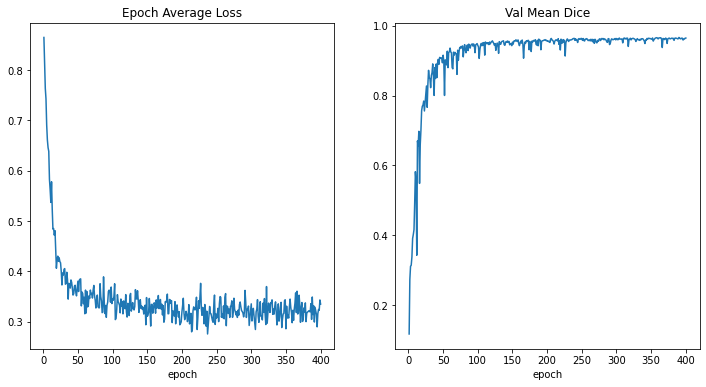

In [18]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

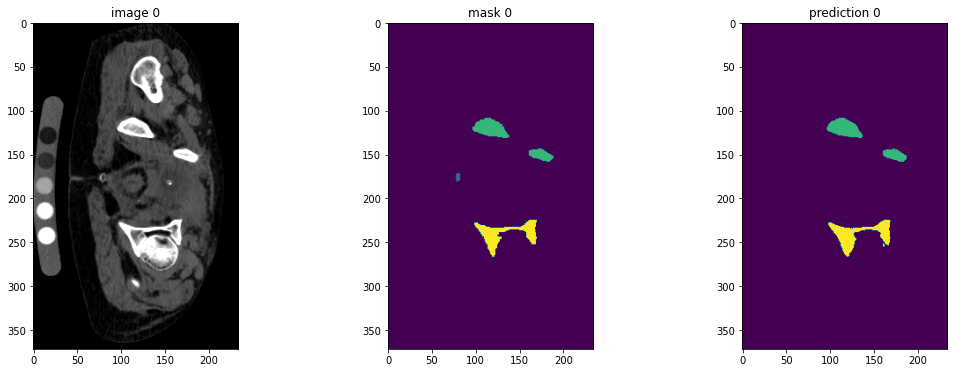

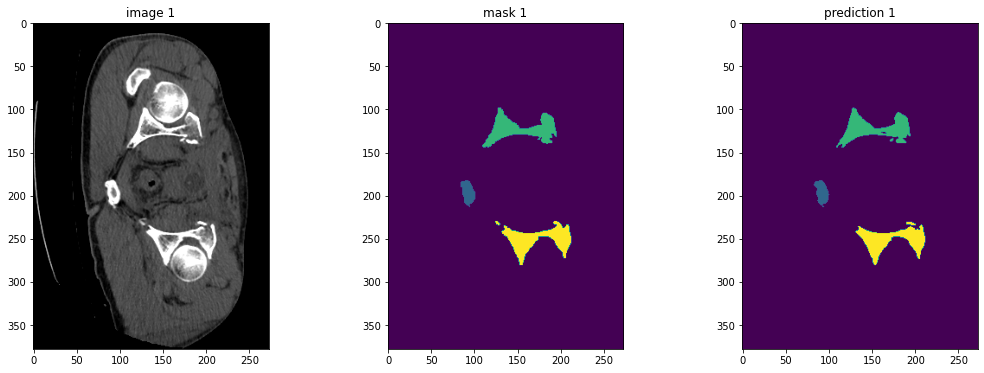

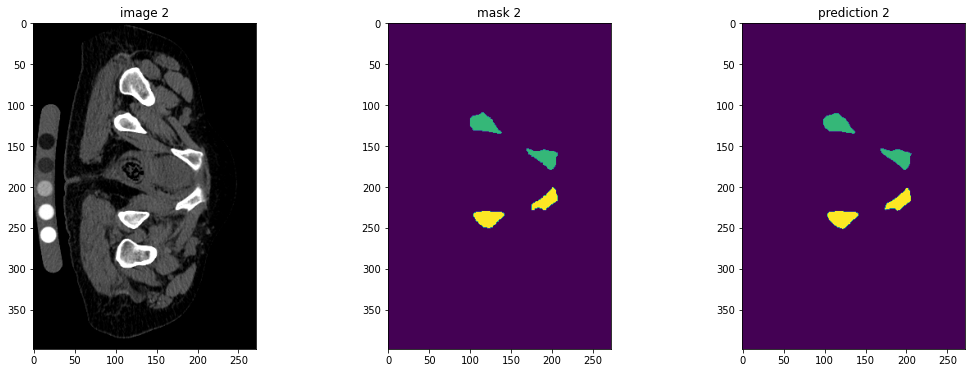

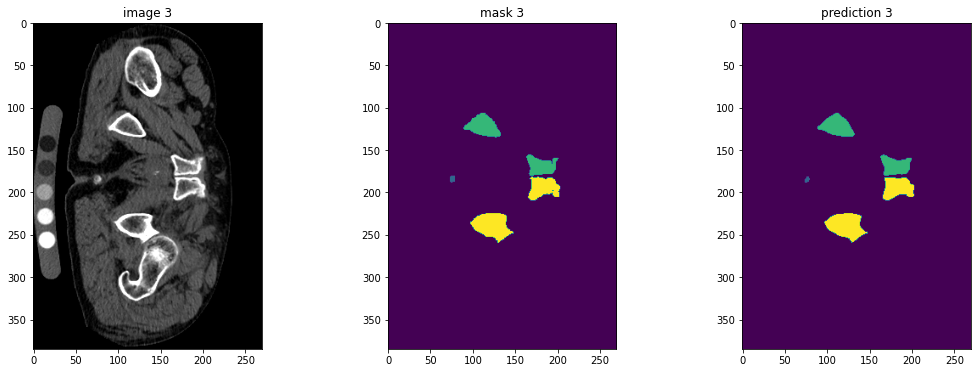

In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        
        val_inputs = val_data["image"].to(device)
        val_outputs = inference(val_inputs)
        
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        
        plt.subplot(1, 3, 2)
        plt.title(f"mask {i}")
        plt.imshow(val_data["mask"][0, 0, :, :, 80])
        
        plt.subplot(1, 3, 3)
        plt.title(f"prediction {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        
        plt.show()
        if i == 3:
            break

## Inference Evaluation of Model

In [20]:
test_image = os.path.join(root_dir, 'test_images')
test_images = sorted(glob.glob(os.path.join(test_image, "*data.nii.gz")))
images_dicts = [{"image": image_name} for image_name in test_images]
test_images = images_dicts[:]

In [21]:
test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
) 

In [22]:
test_org_ds = CacheDataset(data=test_images, transform=test_org_transforms, cache_rate=1.0, num_workers=0)
test_loader = DataLoader(test_org_ds, batch_size=1, num_workers=0)

# test_org_ds = Dataset(data=test_images, transform=test_org_transforms)
# test_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.53s/it]


In [23]:
post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=5),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [24]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model,sw_device="cuda:0", device="cpu")
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)

2022-03-09 01:25:22,793 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0006_data\dataset6_CLINIC_0006_data_seg.nii.gz
2022-03-09 01:25:55,281 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0009_data\dataset6_CLINIC_0009_data_seg.nii.gz
2022-03-09 01:26:26,136 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0015_data\dataset6_CLINIC_0015_data_seg.nii.gz
2022-03-09 01:26:56,316 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0029_data\dataset6_CLINIC_0029_data_seg.nii.gz
2022-03-09 01:27:28,577 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0031_data\dataset6_CLINIC_0031_data_seg.nii.gz


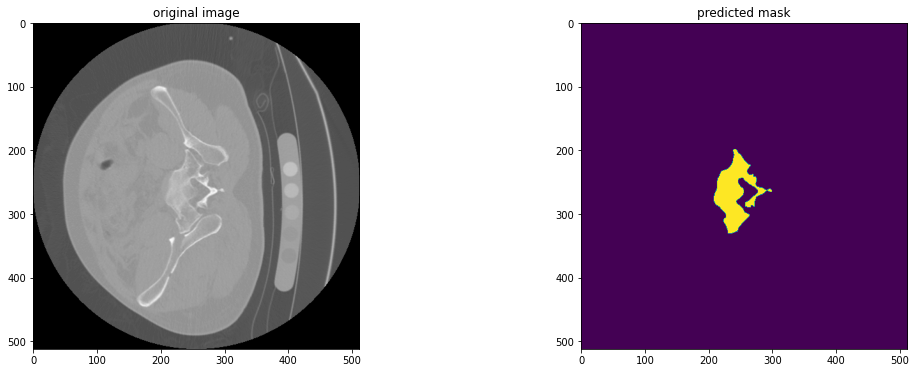

In [25]:
from monai.transforms import LoadImage
loader = LoadImage()

original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

plt.figure("check", (18, 6))
plt.subplot(1, 2, 1)
plt.title(f"original image")
plt.imshow(original_image[:, :, 250], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"predicted mask")
plt.imshow(test_output[0].detach().cpu()[1, :, :, 250])
plt.show()

## Evaluation of Model on original image spacing

In [26]:
test_image = os.path.join(root_dir, 'test_images')
test_mask = os.path.join(root_dir, 'test_masks')

In [27]:
test_images = sorted(glob.glob(os.path.join(test_image, "*data.nii.gz")))
test_labels = sorted(glob.glob(os.path.join(test_mask , "*mask_4label.nii.gz")))

test_dicts = [ {"image": image_name, "mask": label_name} for image_name, label_name in zip(test_images, test_labels) ]
test_files = test_dicts[:]

In [28]:
test_transforms = Compose([
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "mask"]),
    ])


In [29]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader  = DataLoader(test_ds, batch_size=1, num_workers=0)

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=0)
# test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

In [30]:
post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(keys="pred", transform=test_transforms, orig_keys="image", meta_keys="pred_meta_dict", 
            orig_meta_keys="image_meta_dict", meta_key_postfix="meta_dict", nearest_interp=False,to_tensor=True,),
    AsDiscreted(keys="pred", argmax=True, to_onehot=5),
    AsDiscreted(keys="mask", to_onehot=5),
])

In [31]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model,sw_device="cuda:0", device="cpu")
        #uses cuda to run network(window_data) and uses cpu memory to store the final predicted volume
        
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_outputs, test_labels = from_engine(["pred", "mask"])(test_data)
        
        # compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels)

    # aggregate the final mean dice result
    metric_test = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_test)

#test_data["pred"] = inference(test_inputs)


Metric on original image spacing:  0.9649149179458618


In [32]:
from monai.transforms import LoadImage
loader = LoadImage()

original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

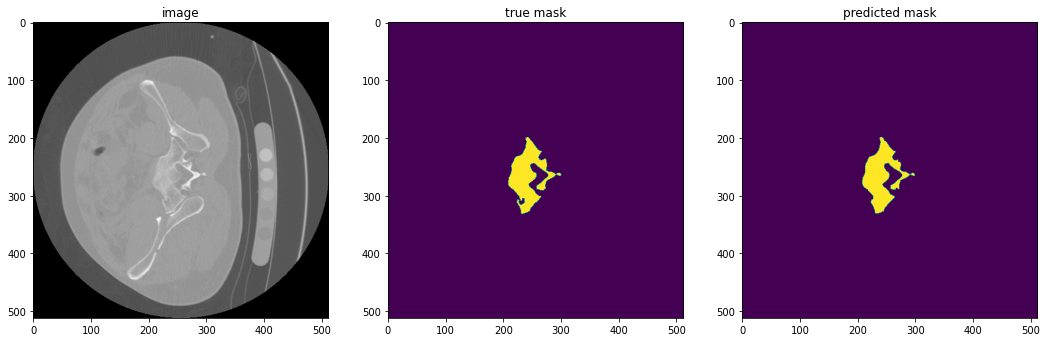

In [53]:
plt.figure("check", (18, 6)) 
plt.subplot(1, 3, 1)
plt.title(f"image")
plt.imshow(original_image[:, :, 250], cmap="gray")
plt.subplot(1, 3, 2)
plt.title(f"true mask")
plt.imshow(test_labels[0].detach().cpu()[1, :, :, 250])
plt.subplot(1, 3, 3)
plt.title(f"predicted mask")
plt.imshow(test_outputs[0].detach().cpu()[1, :, :, 250])
plt.show() 